In [9]:
#
import findspark
findspark.init()
#
import pyspark
from pyspark.sql import functions as pfunc
from pyspark.sql import SQLContext
from pyspark.sql import Window, types
#
import re
import pandas as pd
import numpy as np
from pandas import DataFrame
from pyspark.sql.types import IntegerType
from pyspark.sql.types import FloatType
from pyspark.sql.functions import udf
from pyspark.sql.functions import *
from scipy.stats import kstest
from scipy import stats
#
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import RegexTokenizer
#
#import org.apache.spark.ml.feature.NGram
from pyspark.ml.feature import NGram
#
from collections import Counter
#
from pyspark.ml.feature import NGram
#
from pyspark.ml.feature import NGram, CountVectorizer, VectorAssembler
from pyspark.ml import Pipeline
#
from pyspark.mllib.linalg import SparseVector, DenseVector
#
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
#
#  FILTER with PySpark SQL Functions F.
#
# Arguments
#
import argparse
## Parse date_of execution
#parser = argparse.ArgumentParser()
#parser.add_argument("--datev1", help="Execution Date")
#args = parser.parse_args()
#if args.datev1:
#    processdate = args.datev1
# GENERAL PREPARATION SCRIPT
#
#  Date in format YYYYMMDD
#process_date = processdate
#if not process_date:
#    process_date = "20190122"
#
process_date="20190122"
#
#
sc = pyspark.SparkContext()
#conf = pyspark.SparkConf().setAll([('spark.kryoserializer.buffer.max','2047mb'),('spark.driver.memory','23g'),('spark.driver.maxResultSize','21g')])
conf = pyspark.SparkConf().setAll([('spark.kryoserializer.buffer.max','512mb'),('spark.driver.memory','16g'),('spark.driver.maxResultSize','12g')])
sc.stop()
sc.stop()
sc = pyspark.SparkContext(conf=conf,appName="Notebook-FraudCanada-AUTOML-H2O-Launch")
sqlContext = SQLContext(sc)
#
input_most_frequent_df="hdfs:///data/staged/ott_dazn/advanced-model-data/the-most-frequent-fraud-hash_message/dt="+process_date
input_fraud="hdfs:///data/staged/ott_dazn/advanced-model-data/fraud-notfraud-canada-tokenizedwords-ngrams-7-features-85/dt="+process_date
#
input_file1="hdfs:///data/staged/ott_dazn/advanced-model-data/fraud-notfraud-canada-tokenizedwords-ngrams-7-features-85/dt="+process_date
output_file1="hdfs:///data/staged/ott_dazn/advanced-model-data/label-fraud-notfraud-data-model/dt="+process_date
preserve_training_input_file="hdfs:///data/staged/ott_dazn/advanced-model-data/preserve-training-output-automl-clean/dt="+process_date
#
import h2o
from h2o.automl import H2OAutoML
#
import subprocess
subprocess.run('unset http_proxy', shell=True)
#
# Start an H2O virtual cluster that uses 6 gigs of RAM and 6 cores
h2o.init(ip="localhost",port=54321,max_mem_size = "6g", nthreads = 6) 
#
# Clean up the h2o cluster just in case
h2o.remove_all()
#
#  TRAINING PROCESS
#
print("Start Training Model NGrams Vectors KS KL Entropty")
#
# Horrible code :: close your eyes, is ugly
#
fraud_label_read_file=sqlContext.read.json(output_file1)
fraud_label_read_file.printSchema()
#
fraud_label_read_df=fraud_label_read_file\
.select(col('hash_message').cast('string'),col('fraud_label').cast('int'),\
        col('kl_words').cast('double'), col('ks_words').cast('double'),col('entropy_words').cast('double'),\
        col('features_85.type').alias('features85_type').cast('long'),\
        col('features_85.size').alias('features85_size').cast('long'),\
        col('features_85.indices').alias('features85_indices'),\
        col('features_85.values').alias('features85_values'),\
        col('ngramscounts_7.type').alias('ngramscounts7_type').cast('long'),\
        col('ngramscounts_7.size').alias('ngramscounts7_size').cast('long'),\
        col('ngramscounts_7.indices').alias('ngramscounts7_indices'),\
        col('ngramscounts_7.values').alias('ngramscounts7_values'))
fraud_label_read_df.printSchema()
#
# ABOVE ARE CASE ISSUES on struct Struct of features_85 and ngramscounts_15 
# Both cares conversion to DF valide type list
# Flat vars for each, individually and seperately from the original struct
#
# https://stackoverflow.com/questions/47401418/pyspark-conversion-to-array-types?rq=1 
#
#
fraud_fraud_label_read1_df=fraud_label_read_df.filter("fraud_label=1")\
.persist(pyspark.StorageLevel.MEMORY_AND_DISK_2)
notfraud_fraud_label_read1_df=fraud_label_read_df.filter("fraud_label=0")\
.persist(pyspark.StorageLevel.MEMORY_AND_DISK_2)
#
fraud_fraud_label_read1_df.printSchema()
notfraud_fraud_label_read1_df.printSchema()
#
drop_list_cols=['features85_indices','features85_values','ngramscounts7_indices','ngramscounts7_values']
#
### 1.) https://stackoverflow.com/questions/38610559/convert-spark-dataframe-column-to-python-list
###    list(spark_df.select('mvv').toPandas()['mvv'])
### 2.) http://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.assign.html
###    df.assign(temp_f=lambda x: x['temp_c'] * 9 / 5 + 32,temp_k=lambda x: (x['temp_f'] +  459.67) * 5 / 9)
### 3.) https://stackoverflow.com/questions/43216411/pandas-flatten-a-list-of-list-within-a-column
###    df['var2'] = df['var2'].apply(np.ravel)
fraud_label_train_pd=fraud_fraud_label_read1_df.limit(1200).toPandas()\
.assign(features85_list_indices=lambda x: x['features85_indices'].apply(np.ravel),\
        features85_list_values=lambda x: x['features85_values'].apply(np.ravel),\
        ngramscounts15_list_indices=lambda x: x['ngramscounts7_indices'].apply(np.ravel),\
        ngramscounts15_list_values=lambda x: x['ngramscounts7_values'].apply(np.ravel))\
.drop(drop_list_cols, axis=1, inplace=False)
#.tail(1200)
# dummy_dif=lambda x:list(x['fraud_label'])
#
fraud_label_test_pd=fraud_fraud_label_read1_df.limit(200).toPandas()\
.assign(features85_list_indices=lambda x: x['features85_indices'].apply(np.ravel),\
        features85_list_values=lambda x: x['features85_values'].apply(np.ravel),\
        ngramscounts15_list_indices=lambda x: x['ngramscounts7_indices'].apply(np.ravel),\
        ngramscounts15_list_values=lambda x: x['ngramscounts7_values'].apply(np.ravel))\
.drop(drop_list_cols, axis=1, inplace=False)
#
not_fraud_label_train_pd=notfraud_fraud_label_read1_df.limit(3000).toPandas()\
.assign(features85_list_indices=lambda x: x['features85_indices'].apply(np.ravel),\
        features85_list_values=lambda x: x['features85_values'].apply(np.ravel),\
        ngramscounts15_list_indices=lambda x: x['ngramscounts7_indices'].apply(np.ravel),\
        ngramscounts15_list_values=lambda x: x['ngramscounts7_values'].apply(np.ravel))\
.drop(drop_list_cols, axis=1, inplace=False)
#.tail(3000)
#
not_fraud_label_test_pd=notfraud_fraud_label_read1_df.limit(800).toPandas()\
.assign(features85_list_indices=lambda x: x['features85_indices'].apply(np.ravel),\
        features85_list_values=lambda x: x['features85_values'].apply(np.ravel),\
        ngramscounts15_list_indices=lambda x: x['ngramscounts7_indices'].apply(np.ravel),\
        ngramscounts15_list_values=lambda x: x['ngramscounts7_values'].apply(np.ravel))\
.drop(drop_list_cols, axis=1, inplace=False)
#.head(800)
#
not_fraud_label_train=h2o.H2OFrame(not_fraud_label_train_pd)
not_fraud_label_test=h2o.H2OFrame(not_fraud_label_test_pd)
#
fraud_label_train=h2o.H2OFrame(fraud_label_train_pd)
fraud_label_test=h2o.H2OFrame(fraud_label_test_pd)
#
################# Use Two DataFrames ##################### - rbind() H2o Frames issue
#
#
###### TRAINING PROCESS ############
# RBIND "Merge" all of 3 internal ccrawl and phishtank with rbind .
# function merge() doesn't work if both H2O/dataframes have same variables
#
train = fraud_label_train.rbind(not_fraud_label_train)
test = fraud_label_test.rbind(not_fraud_label_test)
#
print("train")
print(train.head(10))
print("test")
print(test.head(10))
#
# Identify predictors and response
x = train.columns
#
# Fraud Label to be learned in the model from the atrributes of the ngram85 learned words
#
y= 'fraud_label'
x.remove(y)
#
# For binary classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()
#
# http://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html
# Balance Classes to compensate unbalanced data
# Run AutoML for 25 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=2, seed=2, exclude_algos=["DRF","GLM"])
aml.train(x=x, y=y, training_frame=train)
#
print("AutoML Modeling Done!")
#
sc.stop()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,7 mins 06 secs
H2O cluster timezone:,UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.0.1
H2O cluster version age:,3 months and 4 days
H2O cluster name:,H2O_from_python_siemanalyst_o2w67p
H2O cluster total nodes:,1
H2O cluster free memory:,5.082 Gb
H2O cluster total cores:,12
H2O cluster allowed cores:,6
H2O cluster status:,"locked, healthy"


Start Training Model NGrams Vectors KS KL Entropty
root
 |-- entropy_words: double (nullable = true)
 |-- features_85: struct (nullable = true)
 |    |-- indices: array (nullable = true)
 |    |    |-- element: long (containsNull = true)
 |    |-- size: long (nullable = true)
 |    |-- type: long (nullable = true)
 |    |-- values: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |-- fraud_label: long (nullable = true)
 |-- hash_message: string (nullable = true)
 |-- kl_words: double (nullable = true)
 |-- ks_words: double (nullable = true)
 |-- ngramscounts_7: struct (nullable = true)
 |    |-- indices: array (nullable = true)
 |    |    |-- element: long (containsNull = true)
 |    |-- size: long (nullable = true)
 |    |-- type: long (nullable = true)
 |    |-- values: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |-- words_conc: string (nullable = true)

root
 |-- hash_message: string (nullable = true)
 |-- fraud_label: i

hash_message,fraud_label,kl_words,ks_words,entropy_words,features85_type,features85_size,ngramscounts7_type,ngramscounts7_size,features85_list_indices,features85_list_values,ngramscounts15_list_indices,ngramscounts15_list_values
589ff83a30fa5d82563f0051bbd9f638d3dc7f102f8c78ab137c17b859e740de35348417e0deb2037cd0188c243c674100eb57f97450c4b942c9d3a1ef86a07b,1,5121.78,0.386449,0.0775856,0,85,0,262144,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 36 38 39 40 41 42 43 44 45 46 47 48 49 50 52 53 54 55 56 61 62 64 65],[1. 2. 3. 4. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.],[ 0 1 2 3 4 5 6 7 8 9 10 11 13 14 16 66 67 68 69 70 177 178 179 180 181 182 204 251 252 253 271 272 312 313 365 366 367 368 369 370 372 373 374 375 376 421 422 423 424 425 426 427 428 532 1571 1572 1573 2192 11252 34066 37414 38053 53880 107530 118147 151451 153151 157542 165039 173164 175457 200498 225178 248326 256834],[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
865fc00f8a94dd1c467c39753bfb2b18626f2827db85a05654caf048e657b6856afad3fef87873197e7f92e0ff760c8f04cd5484c910a037476643addfdb5c31,1,3572.81,0.999849,0.067809,0,85,0,262144,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 36 38 39 40 41 42 43 44 45 46 47 48 49 50 52 53 54 55 56 61 62 65],[1. 2. 3. 4. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.],[ 0 1 2 3 4 5 6 7 8 9 10 11 13 14 16 66 67 68 69 70 118 119 120 177 178 179 180 181 182 204 271 272 312 313 365 366 367 368 369 370 372 373 374 375 376 421 422 423 424 425 426 427 428 1865 2230 2232 2235 2236 2241 2243 3886 7562 7568 7582 7607 14405 68027 75483 164582 165043 165367 175425 175520 180996 184417 185996 187535 188665 193025 193815 195327 199807],[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
a659ae2c8efbde6eb990b90acae3e02f644e44cd1a3a9aa6490632209641eb5714bb4b740ddcbe95e50b5cd319a8725634ffea38ae633fd6ab1f7114ad8c17bd,1,4872.41,0.629505,0.0770424,0,85,0,262144,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 36 38 39 40 41 42 43 44 45 46 47 48 49 50 52 53 54 55 56 61 62 64 65],[1. 2. 3. 4. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.],[ 0 1 2 3 4 5 6 7 8 9 10 11 13 14 16 66 67 68 69 70 177 178 179 180 181 182 204 271 272 312 313 365 366 367 368 369 370 372 373 374 375 376 421 422 423 424 425 426 427 428 2207 2213 2217 2773 3348 12838 12916 12931 34577 40691 65226 166196 169961 170634 180692 181452 189598 195585 206044 208726 236787 241774],[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
d6d7bcd45dfa2fb6487352a532359f3f64afe250dacb422898ed9854af8992866bff17dac83f36763b46f2db2e0442fdf23fafdd58628636ca3395b6ef019a16,1,4971.4,0.477263,0.0765636,0,85,0,262144,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 36 38 39 40 41 42 43 44 45 46 47 48 49 50 52 53 54 55 56 61 62 64 65],[1. 2. 3. 4. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.],[ 0 1 2 3 4 5 6 7 8 9 10 11 13 


test


hash_message,fraud_label,kl_words,ks_words,entropy_words,features85_type,features85_size,ngramscounts7_type,ngramscounts7_size,features85_list_indices,features85_list_values,ngramscounts15_list_indices,ngramscounts15_list_values
589ff83a30fa5d82563f0051bbd9f638d3dc7f102f8c78ab137c17b859e740de35348417e0deb2037cd0188c243c674100eb57f97450c4b942c9d3a1ef86a07b,1,5121.78,0.386449,0.0775856,0,85,0,262144,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 36 38 39 40 41 42 43 44 45 46 47 48 49 50 52 53 54 55 56 61 62 64 65],[1. 2. 3. 4. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.],[ 0 1 2 3 4 5 6 7 8 9 10 11 13 14 16 66 67 68 69 70 177 178 179 180 181 182 204 251 252 253 271 272 312 313 365 366 367 368 369 370 372 373 374 375 376 421 422 423 424 425 426 427 428 532 1571 1572 1573 2192 11252 34066 37414 38053 53880 107530 118147 151451 153151 157542 165039 173164 175457 200498 225178 248326 256834],[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
865fc00f8a94dd1c467c39753bfb2b18626f2827db85a05654caf048e657b6856afad3fef87873197e7f92e0ff760c8f04cd5484c910a037476643addfdb5c31,1,3572.81,0.999849,0.067809,0,85,0,262144,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 36 38 39 40 41 42 43 44 45 46 47 48 49 50 52 53 54 55 56 61 62 65],[1. 2. 3. 4. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.],[ 0 1 2 3 4 5 6 7 8 9 10 11 13 14 16 66 67 68 69 70 118 119 120 177 178 179 180 181 182 204 271 272 312 313 365 366 367 368 369 370 372 373 374 375 376 421 422 423 424 425 426 427 428 1865 2230 2232 2235 2236 2241 2243 3886 7562 7568 7582 7607 14405 68027 75483 164582 165043 165367 175425 175520 180996 184417 185996 187535 188665 193025 193815 195327 199807],[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
a659ae2c8efbde6eb990b90acae3e02f644e44cd1a3a9aa6490632209641eb5714bb4b740ddcbe95e50b5cd319a8725634ffea38ae633fd6ab1f7114ad8c17bd,1,4872.41,0.629505,0.0770424,0,85,0,262144,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 36 38 39 40 41 42 43 44 45 46 47 48 49 50 52 53 54 55 56 61 62 64 65],[1. 2. 3. 4. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.],[ 0 1 2 3 4 5 6 7 8 9 10 11 13 14 16 66 67 68 69 70 177 178 179 180 181 182 204 271 272 312 313 365 366 367 368 369 370 372 373 374 375 376 421 422 423 424 425 426 427 428 2207 2213 2217 2773 3348 12838 12916 12931 34577 40691 65226 166196 169961 170634 180692 181452 189598 195585 206044 208726 236787 241774],[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
d6d7bcd45dfa2fb6487352a532359f3f64afe250dacb422898ed9854af8992866bff17dac83f36763b46f2db2e0442fdf23fafdd58628636ca3395b6ef019a16,1,4971.4,0.477263,0.0765636,0,85,0,262144,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 36 38 39 40 41 42 43 44 45 46 47 48 49 50 52 53 54 55 56 61 62 64 65],[1. 2. 3. 4. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.],[ 0 1 2 3 4 5 6 7 8 9 10 11 13 


AutoML progress: |████████████████████████████████████████████████████████| 100%
AutoML Modeling Done!


In [10]:
# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

model_id,auc,logloss,mean_per_class_error,rmse,mse
XGBoost_1_AutoML_20190131_195021,0.999964,0.0122988,0.00277521,0.0467558,0.00218611
StackedEnsemble_AllModels_AutoML_20190131_195021,0.999936,0.00750126,0.00296122,0.041681,0.00173731
StackedEnsemble_BestOfFamily_AutoML_20190131_195021,0.999933,0.00741378,0.00277521,0.0412108,0.00169833
XGBoost_2_AutoML_20190131_195021,0.999765,0.0262509,0.00547987,0.0746624,0.00557447


In [11]:
# The leader model is stored here
aml.leader

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_1_AutoML_20190131_195021


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.0005921542754710775
RMSE: 0.024334220256073083
LogLoss: 0.006472747272563878
Mean Per-Class Error: 0.0
AUC: 1.0
pr_auc: 0.9944495837187789
Gini: 1.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40486258268356323: 


,0,1,Error,Rate
0,2688.0,0.0,0.0,(0.0/2688.0)
1,0.0,1081.0,0.0,(0.0/1081.0)
Total,2688.0,1081.0,0.0,(0.0/3769.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.4048626,1.0,183.0
max f2,0.4048626,1.0,183.0
max f0point5,0.4048626,1.0,183.0
max accuracy,0.4048626,1.0,183.0
max precision,0.9993216,1.0,0.0
max recall,0.4048626,1.0,183.0
max specificity,0.9993216,1.0,0.0
max absolute_mcc,0.4048626,1.0,183.0
max min_per_class_accuracy,0.4048626,1.0,183.0
max mean_per_class_accuracy,0.4048626,1.0,183.0


Gains/Lift Table: Avg response rate: 28.68 %, avg score: 28.68 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100822,0.9989340,3.4865865,3.4865865,1.0,0.9990463,1.0,0.9990463,0.0351526,0.0351526,248.6586494,248.6586494
,2,0.0204298,0.9988198,3.4865865,3.4865865,1.0,0.9988648,1.0,0.9989544,0.0360777,0.0712303,248.6586494,248.6586494
,3,0.0302467,0.9987422,3.4865865,3.4865865,1.0,0.9987755,1.0,0.9988963,0.0342276,0.1054579,248.6586494,248.6586494
,4,0.0400637,0.9986816,3.4865865,3.4865865,1.0,0.9987071,1.0,0.9988500,0.0342276,0.1396855,248.6586494,248.6586494
,5,0.0501459,0.9985771,3.4865865,3.4865865,1.0,0.9986334,1.0,0.9988064,0.0351526,0.1748381,248.6586494,248.6586494
,6,0.1000265,0.9981190,3.4865865,3.4865865,1.0,0.9983695,1.0,0.9985885,0.1739130,0.3487512,248.6586494,248.6586494
,7,0.1501725,0.9974291,3.4865865,3.4865865,1.0,0.9978388,1.0,0.9983382,0.1748381,0.5235893,248.6586494,248.6586494
,8,0.2000531,0.9951687,3.4865865,3.4865865,1.0,0.9964855,1.0,0.9978762,0.1739130,0.6975023,248.6586494,248.6586494
,9,0.3000796,0.0398742,3.0241745,3.3324492,0.8673740,0.8528871,0.9557913,0.9495465,0.3024977,1.0,202.4174492,233.2449160
,10,0.4001061,0.0034661,0.0,2.4993369,0.0,0.0127208,0.7168435,0.7153401,0.0,1.0,-100.0,149.9336870




ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.002011953765491128
RMSE: 0.044854807607336004
LogLoss: 0.01013712660941332
Mean Per-Class Error: 0.0
AUC: 1.0
pr_auc: 0.9915966386554622
Gini: 1.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3025875985622406: 


,0,1,Error,Rate
0,312.0,0.0,0.0,(0.0/312.0)
1,0.0,119.0,0.0,(0.0/119.0)
Total,312.0,119.0,0.0,(0.0/431.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3025876,1.0,118.0
max f2,0.3025876,1.0,118.0
max f0point5,0.3025876,1.0,118.0
max accuracy,0.3025876,1.0,118.0
max precision,0.9991211,1.0,0.0
max recall,0.3025876,1.0,118.0
max specificity,0.9991211,1.0,0.0
max absolute_mcc,0.3025876,1.0,118.0
max min_per_class_accuracy,0.3025876,1.0,118.0
max mean_per_class_accuracy,0.3025876,1.0,118.0


Gains/Lift Table: Avg response rate: 27.61 %, avg score: 27.40 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0116009,0.9988623,3.6218487,3.6218487,1.0,0.9990023,1.0,0.9990023,0.0420168,0.0420168,262.1848739,262.1848739
,2,0.0208817,0.9987661,3.6218487,3.6218487,1.0,0.9988066,1.0,0.9989153,0.0336134,0.0756303,262.1848739,262.1848739
,3,0.0301624,0.9986992,3.6218487,3.6218487,1.0,0.9987331,1.0,0.9988593,0.0336134,0.1092437,262.1848739,262.1848739
,4,0.0417633,0.9985608,3.6218487,3.6218487,1.0,0.9986417,1.0,0.9987988,0.0420168,0.1512605,262.1848739,262.1848739
,5,0.0510441,0.9984757,3.6218487,3.6218487,1.0,0.9985477,1.0,0.9987532,0.0336134,0.1848739,262.1848739,262.1848739
,6,0.1020882,0.9976913,3.6218487,3.6218487,1.0,0.9981694,1.0,0.9984613,0.1848739,0.3697479,262.1848739,262.1848739
,7,0.1508121,0.9969806,3.6218487,3.6218487,1.0,0.9974239,1.0,0.9981261,0.1764706,0.5462185,262.1848739,262.1848739
,8,0.2018561,0.9946046,3.6218487,3.6218487,1.0,0.9959533,1.0,0.9975767,0.1848739,0.7310924,262.1848739,262.1848739
,9,0.3016241,0.0329163,2.6953293,3.3153846,0.7441860,0.7113962,0.9153846,0.9029170,0.2689076,1.0,169.5329295,231.5384615
,10,0.4013921,0.0028399,0.0,2.4913295,0.0,0.0107244,0.6878613,0.6811581,0.0,1.0,-100.0,149.1329480




ModelMetricsBinomial: xgboost
** Reported on cross-validation data. **

MSE: 0.0021861064361371283
RMSE: 0.04675581713687751
LogLoss: 0.012298810685168598
Mean Per-Class Error: 0.0024131646182987687
AUC: 0.9999636924034183
pr_auc: 0.9925126528501738
Gini: 0.9999273848068366
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5180469751358032: 


,0,1,Error,Rate
0,2688.0,0.0,0.0,(0.0/2688.0)
1,6.0,1075.0,0.0056,(6.0/1081.0)
Total,2694.0,1075.0,0.0016,(6.0/3769.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.5180470,0.9972171,187.0
max f2,0.2533942,0.9970431,199.0
max f0point5,0.5180470,0.9988850,187.0
max accuracy,0.5180470,0.9984081,187.0
max precision,0.9991841,1.0,0.0
max recall,0.0412301,1.0,254.0
max specificity,0.9991841,1.0,0.0
max absolute_mcc,0.5180470,0.9961098,187.0
max min_per_class_accuracy,0.3334783,0.9970238,198.0
max mean_per_class_accuracy,0.2533942,0.9975868,199.0


Gains/Lift Table: Avg response rate: 28.68 %, avg score: 28.59 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100822,0.9988450,3.4865865,3.4865865,1.0,0.9989843,1.0,0.9989843,0.0351526,0.0351526,248.6586494,248.6586494
,2,0.0204298,0.9987292,3.4865865,3.4865865,1.0,0.9987806,1.0,0.9988811,0.0360777,0.0712303,248.6586494,248.6586494
,3,0.0302467,0.9986136,3.4865865,3.4865865,1.0,0.9986669,1.0,0.9988116,0.0342276,0.1054579,248.6586494,248.6586494
,4,0.0400637,0.9985234,3.4865865,3.4865865,1.0,0.9985760,1.0,0.9987539,0.0342276,0.1396855,248.6586494,248.6586494
,5,0.0501459,0.9983689,3.4865865,3.4865865,1.0,0.9984447,1.0,0.9986917,0.0351526,0.1748381,248.6586494,248.6586494
,6,0.1000265,0.9975608,3.4865865,3.4865865,1.0,0.9979931,1.0,0.9983433,0.1739130,0.3487512,248.6586494,248.6586494
,7,0.1501725,0.9964424,3.4865865,3.4865865,1.0,0.9970664,1.0,0.9979169,0.1748381,0.5235893,248.6586494,248.6586494
,8,0.2000531,0.9931936,3.4865865,3.4865865,1.0,0.9951689,1.0,0.9972317,0.1739130,0.6975023,248.6586494,248.6586494
,9,0.3000796,0.0546062,3.0149263,3.3293664,0.8647215,0.8393098,0.9549072,0.9445911,0.3015726,0.9990749,201.4926252,232.9366413
,10,0.4001061,0.0046943,0.0092482,2.4993369,0.0026525,0.0170471,0.7168435,0.7127051,0.0009251,1.0,-99.0751760,149.9336870



Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
accuracy,0.9986734,0.0010273,0.9986737,0.9960212,1.0,1.0,0.998672
auc,0.9999484,0.0000535,0.9999485,0.9998020,1.0,1.0,0.9999914
err,0.0013266,0.0010273,0.0013263,0.0039788,0.0,0.0,0.0013280
err_count,1.0,0.7745967,1.0,3.0,0.0,0.0,1.0
f0point5,0.9974164,0.0022368,0.9990749,0.9916974,1.0,1.0,0.9963099
f1,0.9976906,0.0017889,0.9976906,0.9930716,1.0,1.0,0.9976906
f2,0.9979669,0.0015688,0.9963099,0.9944496,1.0,1.0,0.9990749
lift_top_group,3.4865975,0.0044088,3.4746544,3.4907408,3.4907408,3.4907408,3.4861112
logloss,0.0122987,0.0026704,0.0148713,0.0179246,0.0073067,0.0094743,0.0119165
max_per_class_error,0.0022200,0.0014661,0.0046083,0.0046296,0.0,0.0,0.0018622


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
,2019-01-31 19:50:28,6.765 sec,0.0,0.5,0.6931472,0.5,0.0,1.0,0.7131865,0.5,0.6931472,0.5,0.0,1.0,0.7238979
,2019-01-31 19:50:28,6.822 sec,5.0,0.3910224,0.4958747,0.9999506,0.9869281,3.4865865,0.0029185,0.3916266,0.4968322,0.9997172,0.9657028,3.6218487,0.0023202
,2019-01-31 19:50:28,6.852 sec,10.0,0.3067588,0.3659502,0.9999754,0.9980893,3.4865865,0.0018573,0.3073350,0.3666506,0.9997845,0.9910652,3.6218487,0.0023202
,2019-01-31 19:50:28,6.886 sec,15.0,0.2423424,0.2765023,0.9999954,0.9981384,3.4865865,0.0002653,0.2430812,0.2772235,1.0,0.9915966,3.6218487,0.0
,2019-01-31 19:50:28,6.917 sec,20.0,0.1934272,0.2129512,0.9999943,0.9981359,3.4865865,0.0002653,0.1941381,0.2135821,1.0,0.9915966,3.6218487,0.0
---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---
,2019-01-31 19:50:29,8.370 sec,195.0,0.0251191,0.0067518,1.0,0.9972248,3.4865865,0.0,0.0431924,0.0099485,1.0,0.9915966,3.6218487,0.0
,2019-01-31 19:50:29,8.413 sec,200.0,0.0249220,0.0066794,1.0,0.9972248,3.4865865,0.0,0.0437693,0.0100017,1.0,0.9915966,3.6218487,0.0
,2019-01-31 19:50:29,8.455 sec,205.0,0.0247068,0.0065597,1.0,0.9972248,3.4865865,0.0,0.0444421,0.0100675,1.0,0.9915966,3.6218487,0.0
,2019-01-31 19:50:29,8.497 sec,210.0,0.0245873,0.0065108,1.0,0.9953747,3.4865865,0.0,0.0450458,0.0101888,1.0,0.9915966,3.6218487,0.0



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
ks_words,407.0,1.0,0.2622423
entropy_words,403.0,0.9901720,0.2596649
kl_words,357.0,0.8771499,0.2300258
features85_list_values.,182.0,0.4471744,0.1172680
features85_list_indices.,133.0,0.3267813,0.0856959
ngramscounts15_list_values.,70.0,0.1719902,0.0451031


In [6]:
# Get model ids for all models in the AutoML Leaderboard
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])

print(model_ids)
# Get the "All Models" Stacked Ensemble model
se = h2o.get_model([mid for mid in model_ids if "StackedEnsemble" in mid][0])
print(se)

# Get the Stacked Ensemble metalearner model
metalearner = h2o.get_model(aml.leader.metalearner()['name'])
metalearner.coef_norm()

['StackedEnsemble_BestOfFamily_AutoML_20190131_194502', 'XGBoost_1_AutoML_20190131_194502', 'StackedEnsemble_AllModels_AutoML_20190131_194502', 'XGBoost_2_AutoML_20190131_194502']
Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_AutoML_20190131_194502
No model summary for this model


ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 0.00015216958360823833
RMSE: 0.012335703612207871
MAE: 0.0025070884266458343
RMSLE: 0.008129833595818023
R^2: 0.9992560818258368
Mean Residual Deviance: 0.00015216958360823833
Null degrees of freedom: 3768
Residual degrees of freedom: 3767
Null deviance: 770.954629875314
Residual deviance: 0.5735271606194503
AIC: -22429.492286505225

ModelMetricsRegressionGLM: stackedensemble
** Reported on validation data. **

MSE: 6.968606218127323e-05
RMSE: 0.008347817809540001
MAE: 0.0031162117078342463
RMSLE: 0.00668425366366763
R^2: 0.9996513425825023
Mean Residual Deviance: 6.96860621

{'Intercept': 0.28681347837622717,
 'XGBoost_1_AutoML_20190131_194502': 0.4517060558963961}

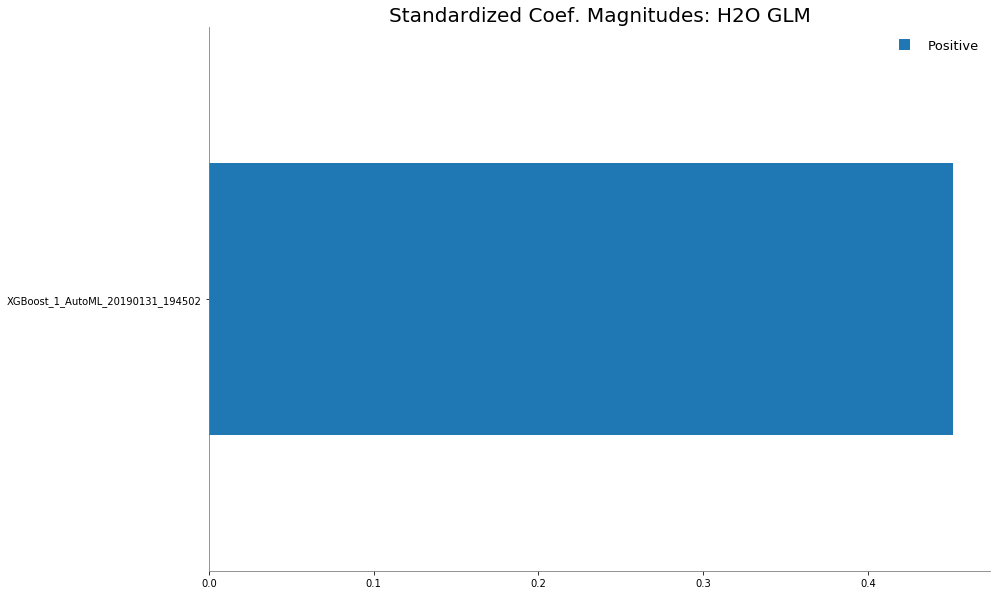

In [7]:
%matplotlib inline
metalearner.std_coef_plot()

In [12]:
# If you need to generate predictions on a test set, you can make
# predictions directly on the `"H2OAutoML"` object, or on the leader
# model object directly

#preds = aml.predict(test)
# or:
preds = aml.leader.predict(test)
print("test_fraud_P1")
print(test.head(10))
print("prediction_fraud_P1")
print(preds.head(10))

#preds = aml.predict(test)
# or:
preds = aml.leader.predict(test)
print("test_notfraud_P0")
print(test.tail(10))
print("prediction_notfraud_P0")
print(preds.tail(10))

xgboost prediction progress: |████████████████████████████████████████████| 100%
test_fraud_P1


hash_message,fraud_label,kl_words,ks_words,entropy_words,features85_type,features85_size,ngramscounts7_type,ngramscounts7_size,features85_list_indices,features85_list_values,ngramscounts15_list_indices,ngramscounts15_list_values
589ff83a30fa5d82563f0051bbd9f638d3dc7f102f8c78ab137c17b859e740de35348417e0deb2037cd0188c243c674100eb57f97450c4b942c9d3a1ef86a07b,1,5121.78,0.386449,0.0775856,0,85,0,262144,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 36 38 39 40 41 42 43 44 45 46 47 48 49 50 52 53 54 55 56 61 62 64 65],[1. 2. 3. 4. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.],[ 0 1 2 3 4 5 6 7 8 9 10 11 13 14 16 66 67 68 69 70 177 178 179 180 181 182 204 251 252 253 271 272 312 313 365 366 367 368 369 370 372 373 374 375 376 421 422 423 424 425 426 427 428 532 1571 1572 1573 2192 11252 34066 37414 38053 53880 107530 118147 151451 153151 157542 165039 173164 175457 200498 225178 248326 256834],[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
865fc00f8a94dd1c467c39753bfb2b18626f2827db85a05654caf048e657b6856afad3fef87873197e7f92e0ff760c8f04cd5484c910a037476643addfdb5c31,1,3572.81,0.999849,0.067809,0,85,0,262144,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 36 38 39 40 41 42 43 44 45 46 47 48 49 50 52 53 54 55 56 61 62 65],[1. 2. 3. 4. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.],[ 0 1 2 3 4 5 6 7 8 9 10 11 13 14 16 66 67 68 69 70 118 119 120 177 178 179 180 181 182 204 271 272 312 313 365 366 367 368 369 370 372 373 374 375 376 421 422 423 424 425 426 427 428 1865 2230 2232 2235 2236 2241 2243 3886 7562 7568 7582 7607 14405 68027 75483 164582 165043 165367 175425 175520 180996 184417 185996 187535 188665 193025 193815 195327 199807],[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
a659ae2c8efbde6eb990b90acae3e02f644e44cd1a3a9aa6490632209641eb5714bb4b740ddcbe95e50b5cd319a8725634ffea38ae633fd6ab1f7114ad8c17bd,1,4872.41,0.629505,0.0770424,0,85,0,262144,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 36 38 39 40 41 42 43 44 45 46 47 48 49 50 52 53 54 55 56 61 62 64 65],[1. 2. 3. 4. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.],[ 0 1 2 3 4 5 6 7 8 9 10 11 13 14 16 66 67 68 69 70 177 178 179 180 181 182 204 271 272 312 313 365 366 367 368 369 370 372 373 374 375 376 421 422 423 424 425 426 427 428 2207 2213 2217 2773 3348 12838 12916 12931 34577 40691 65226 166196 169961 170634 180692 181452 189598 195585 206044 208726 236787 241774],[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
d6d7bcd45dfa2fb6487352a532359f3f64afe250dacb422898ed9854af8992866bff17dac83f36763b46f2db2e0442fdf23fafdd58628636ca3395b6ef019a16,1,4971.4,0.477263,0.0765636,0,85,0,262144,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 36 38 39 40 41 42 43 44 45 46 47 48 49 50 52 53 54 55 56 61 62 64 65],[1. 2. 3. 4. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.],[ 0 1 2 3 4 5 6 7 8 9 10 11 13 


prediction_fraud_P1


predict,p0,p1
1,0.00210613,0.997894
1,0.0273623,0.972638
1,0.00162053,0.998379
1,0.00130993,0.99869
1,0.00159186,0.998408
1,0.0393653,0.960635
1,0.00113225,0.998868
1,0.00159234,0.998408
1,0.00119936,0.998801
1,0.0027433,0.997257



xgboost prediction progress: |████████████████████████████████████████████| 100%
test_notfraud_P0


hash_message,fraud_label,kl_words,ks_words,entropy_words,features85_type,features85_size,ngramscounts7_type,ngramscounts7_size,features85_list_indices,features85_list_values,ngramscounts15_list_indices,ngramscounts15_list_values
28eb4e7f40b2576348154859edd355cd5d4c0f751bae54055dc3654b0a2df966e1274f09b5e9c09292ff4395df798ce9a02b5cfbf9071c9bc6765bf2812e9a35,0,6142.85,0.00500494,0.0666371,0,85,0,262144,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 47 48 49 51 52 53 54 56 57 59 61 62 63 65 67 68 69 70 71 72],[3. 2. 3. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.],[ 0 1 2 3 4 5 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 28 29 32 33 34 35 38 39 40 41 42 45 46 47 48 49 50 51 52 53 54 60 61 66 67 68 69 70 121 122 123 124 308 443 445 700 701 702 703 704 109623 111281 121250 123103 125863 138740],[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
29c6c59805df1ca6a084f2f9f7f81b89958f8a5caf9299595ea9604ef72fa766efeff77e58e098f6a3778f1b11e0362f22d7ad79269e92b2f2a035127f761e2f,0,3172.75,0.844631,0.0662526,0,85,0,262144,[ 0 1 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 36 42 43 44 45 46 50 55 58 61 62 66 73 75 78 80],[3. 4. 2. 1. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 2. 3. 1. 1.],[ 0 1 2 3 4 6 7 8 125 126 127 128 129 130 131 132 134 135 189 240 273 274 277 278 280 281 282 307 310 311 1641 1642 1643 1644 1646 1647 1679 1684 1688 1690 1691 1693 1694 1697 4828 5375 5384 5424 7045 18297 18465 18650 18732 18891 19185 19514 19529 40334 41248 42027 52456 73449 74432 153689 156930 163238 167756 169010 177819 178491 188220 196481],[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
29f957bbd4d764a06c90397f3b80784933af5fe29188b74ddb64290d19063e343af746e26e792b89c67fa6f5346d82339a21aa447e2f6e72aea37e8c815d9c72,0,4761.7,0.93572,0.0683701,0,85,0,262144,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 56 59 60 66 75 78],[3. 2. 3. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.],[ 0 1 2 3 4 5 6 7 8 9 10 11 117 144 145 146 149 197 198 199 219 230 231 232 233 241 251 252 253 409 410 411 418 432 433 434 435 436 437 438 439 440 441 442 444 446 447 448 449 450 451 452 453 454 458 459 706 722 735 736 1091 1092 1094 1095 1096 1097 1098 2984 6596 9443 10572 11034 11039 11088 11120 11170 11200 11220 11302 11316 11332 11376 11435 11440 11484 11487 11502 11593 109418 116514 125433 136327 144773 207403 232035],[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
2a3f4b85be3eedb8be47c3f0ecd48ebca0a6936b663b90716795ae35184bacc9db2aa2620db40850bbb63224f8308e0b133932e88e9dce64377bce35631dd5d4,0,2297.75,0.415852,0.0652195,0,85,0,262144,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 58 60 64 66 80],[3. 2. 2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.


prediction_notfraud_P0


predict,p0,p1
0,0.999506,0.00049359
0,0.999231,0.00076858
0,0.994955,0.00504472
0,0.999601,0.00039866
0,0.998563,0.00143677
0,0.999035,0.000964606
0,0.999506,0.000494037
0,0.998352,0.0016484
0,0.999558,0.000441542
0,0.999509,0.000491462


In [ ]:
sc.stop()